주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [1]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [2]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [3]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('/content/drive/MyDrive/DSL/정규세션1/0209_Clustering/marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
column = data.columns.values.tolist()
column

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response']

### 데이터 전처리

In [7]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d")) #datetime 타입으로 변환
data.Dt_Customer = pd.to_datetime(data.Dt_Customer) #datetime 타입으로 변환
data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype('int')# #int형으로 변환
data['days'][:5]


0    3814
1    3264
2    3463
3    3290
4    3312
Name: days, dtype: int64

In [8]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [9]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis=1)

## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

In [10]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [11]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [12]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))

###차원 축소

데이터를 차원 축소 해봅시다.

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

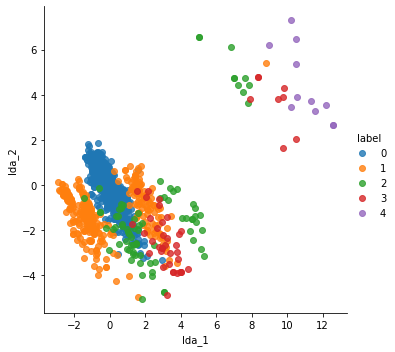

In [15]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [17]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

In [38]:
## 클러스터 수는 4로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 4)

y_km = km.fit_predict(X_features_scaling)
y_km

array([2, 1, 2, ..., 0, 2, 1], dtype=int32)

In [39]:
X_train_lda['K_means'] = y_km

####시각화

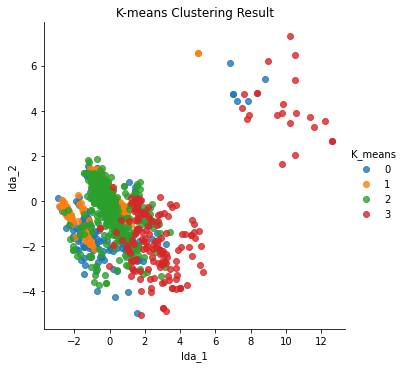

In [40]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [41]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [43]:
## 클러스터 수는 4로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling)
y_agghc

array([2, 3, 2, ..., 0, 2, 0])

In [44]:
X_train_lda['hierarchical'] = y_agghc

####시각화

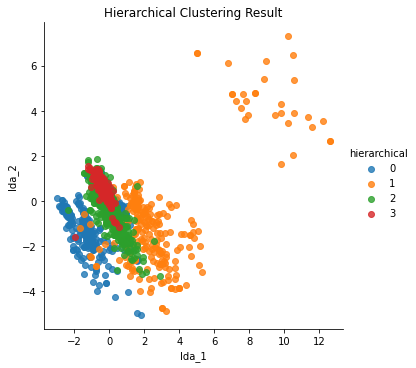

In [45]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [46]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN

In [47]:
## eps는 0.5, minPts는 4로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 0.5, min_samples = 4, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit_predict(X_features_scaling)
y_dbscan

array([-1, -1, -1, ..., -1, -1, -1])

In [48]:
X_train_lda['dbscan'] = y_dbscan

####시각화

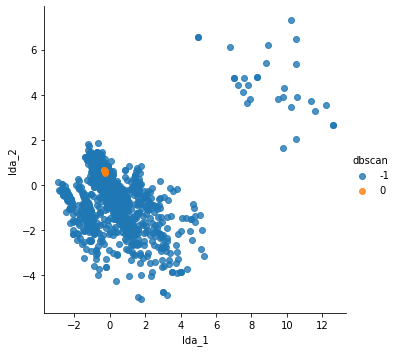

In [49]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

########(의견)########

hierarchical clustering > k-means > dbscan



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [50]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [51]:
coef_km = metrics.silhouette_score(X_features_scaling,y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.19062058158068393.


Hierarchical Clustering의 실루엣 계수입니다.

In [52]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.17142231156823046.


DBSCAN의 실루엣 계수입니다.

In [54]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling, y_dbscan)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is -0.2255937075525873.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

########(의견)########


k-means > Hiearchical clustering > dbscan

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

########(의견)########


실루엣 계수가 높은 순서대로 군집화가 잘 되었음을 알 수 있다. 

(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

########(의견)########
k-means 결과를 토대로 봤을 때, 소수의 경우를 제외하면 그룹 2의 캠페인 참여도가 가장 높음을 알 수 있다. 